### Dependencies

In [1]:
import sys
sys.path.append('../Scripts/')

In [2]:
from utillity_script_cloud_segmentation import *
from utillity_script_lr_schedulers import *

C:\Users\virtus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\virtus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\virtus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\virtus\AppData\Roaming\Python\Python36\s

Segmentation Models: using `keras` framework.


In [3]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [4]:
train_path = '../data/train.csv'
kfold_set_path = '../data/3-fold.csv'
train_images_path = '../data/train_images320x480/'

### Load data

In [5]:
train = pd.read_csv(train_path)
kfold_set = pd.read_csv(kfold_set_path)

X_train = kfold_set[kfold_set['fold_0'] == 'train']
X_val = kfold_set[kfold_set['fold_0'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

display(X_train.head())

Compete set samples: 22184
Train samples:  3682
Validation samples:  1843


,image,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,fold_0,fold_1,fold_2
0,0011165.jpg,1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,train,validation,train
1,002be4f.jpg,1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,train,validation,train
2,0031ae9.jpg,1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,train,train,validation
4,003994e.jpg,1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,train,validation,train
5,00498ec.jpg,0,0,0,1,NaN,NaN,326420 552 327820 552 329220 552 330620 552 33...,NaN,train,validation,train


# Model parameters

In [6]:
N_GPUS = 3
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
EPOCHS = 15
LEARNING_RATE = 10**(-1.7)
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 8
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE
BATCH_SIZE *= N_GPUS

model_0_path = 'files/57-unet[fold-1]_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)
model_1_path = 'files/57-unet[fold-2]_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)
model_2_path = 'files/57-unet[fold-3]_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)

In [7]:
class OneCycleLR(Callback):
    def __init__(self,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = None
        self.samples = None
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

#         self.epochs = self.params['epochs']
#         self.batch_size = self.params['batch_size']
#         self.samples = self.params['samples']
#         self.steps = self.params['steps']
        self.epochs = EPOCHS
        self.batch_size = BATCH_SIZE
        self.samples = len(X_train)
        self.steps = len(X_train)//BATCH_SIZE
        

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))

In [8]:
preprocessing = sm.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, 
                                                   shift_limit=0.1, border_mode=0, p=0.5)
                            ])

### Data generator

In [9]:
train_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

## Learning rate finder

In [10]:
from keras.utils import multi_gpu_model

Epoch 1/1
460/460 [==============================] - 1264s 3s/step - loss: 2.5213


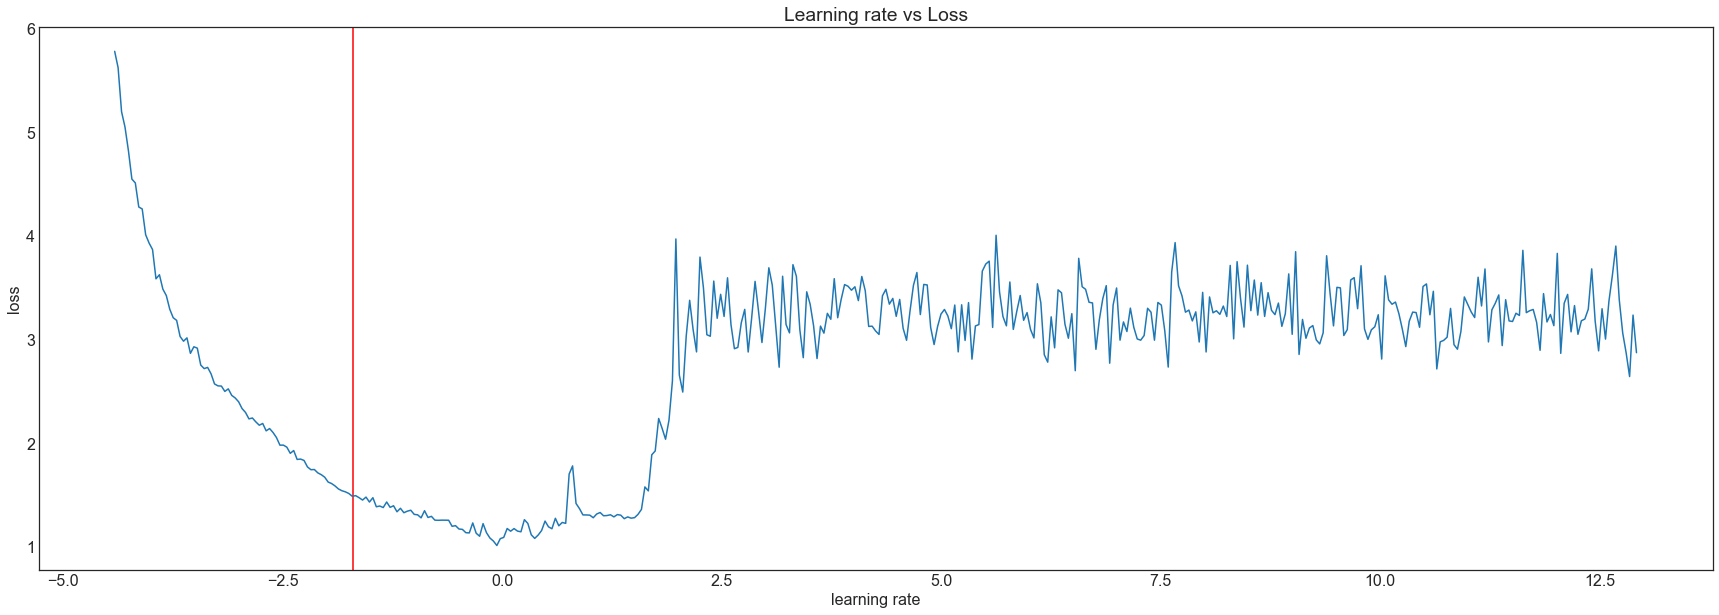

In [37]:
model_s = sm.Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(None, None, CHANNELS))

lr_finder = LRFinder(num_samples=len(X_train), batch_size=BATCH_SIZE, minimum_lr=1e-5, maximum_lr=10, verbose=0)

optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)

model = multi_gpu_model(model_s, gpus=N_GPUS)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss)

history = model.fit_generator(generator=train_generator, 
                              steps_per_epoch=STEP_SIZE_TRAIN, 
                              epochs=1, 
                              callbacks=[lr_finder])

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(30, 10))
plt.axvline(x=np.log10(LEARNING_RATE), color='red')
lr_finder.plot_schedule(clip_beginning=15)

# Fold 1

In [38]:
model_s = sm.Unet(backbone_name=BACKBONE, 
                  encoder_weights='imagenet',
                  classes=N_CLASSES,
                  activation='sigmoid',
                  input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_0_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
oneCycleLR = OneCycleLR(max_lr=LEARNING_RATE, maximum_momentum=0.9, minimum_momentum=0.9)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, oneCycleLR]
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)

model = multi_gpu_model(model_s, gpus=N_GPUS)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)

C:\Users\virtus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:125: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.float_val.extend([np.asscalar(x) for x in proto_values])
C:\Users\virtus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:131: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.int_val.extend([np.asscalar(x) for x in proto_values])
C:\Users\virtus\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\tensor_util.py:134: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  tensor_proto.int64_val.extend([np.asscalar(x) for x in proto_values])


In [39]:
history1 = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/15


c:\program files\python36\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (6.577741). Check your callbacks.
  % delta_t_median)


 - 1901s - loss: 1.1423 - dice_coef: 0.2634 - iou_score: 0.1529 - f1-score: 0.2604 - val_loss: 1.1086 - val_dice_coef: 0.4117 - val_iou_score: 0.2680 - val_f1-score: 0.4125
 - lr: 0.00998 - momentum: 0.90 
Epoch 2/15
 - 1795s - loss: 0.8941 - dice_coef: 0.4387 - iou_score: 0.2840 - f1-score: 0.4359 - val_loss: 0.8371 - val_dice_coef: 0.5165 - val_iou_score: 0.3499 - val_f1-score: 0.5123
 - lr: 0.01799 - momentum: 0.90 
Epoch 3/15
 - 1797s - loss: 0.8162 - dice_coef: 0.4940 - iou_score: 0.3302 - f1-score: 0.4911 - val_loss: 0.7838 - val_dice_coef: 0.5312 - val_iou_score: 0.3607 - val_f1-score: 0.5248
 - lr: 0.01391 - momentum: 0.90 
Epoch 4/15
 - 1802s - loss: 0.7829 - dice_coef: 0.5171 - iou_score: 0.3496 - f1-score: 0.5126 - val_loss: 0.7658 - val_dice_coef: 0.5431 - val_iou_score: 0.3740 - val_f1-score: 0.5386
 - lr: 0.00591 - momentum: 0.90 
Epoch 5/15
 - 1802s - loss: 0.7673 - dice_coef: 0.5263 - iou_score: 0.3583 - f1-score: 0.5221 - val_loss: 0.7601 - val_dice_coef: 0.5481 - val_

## Model loss graph

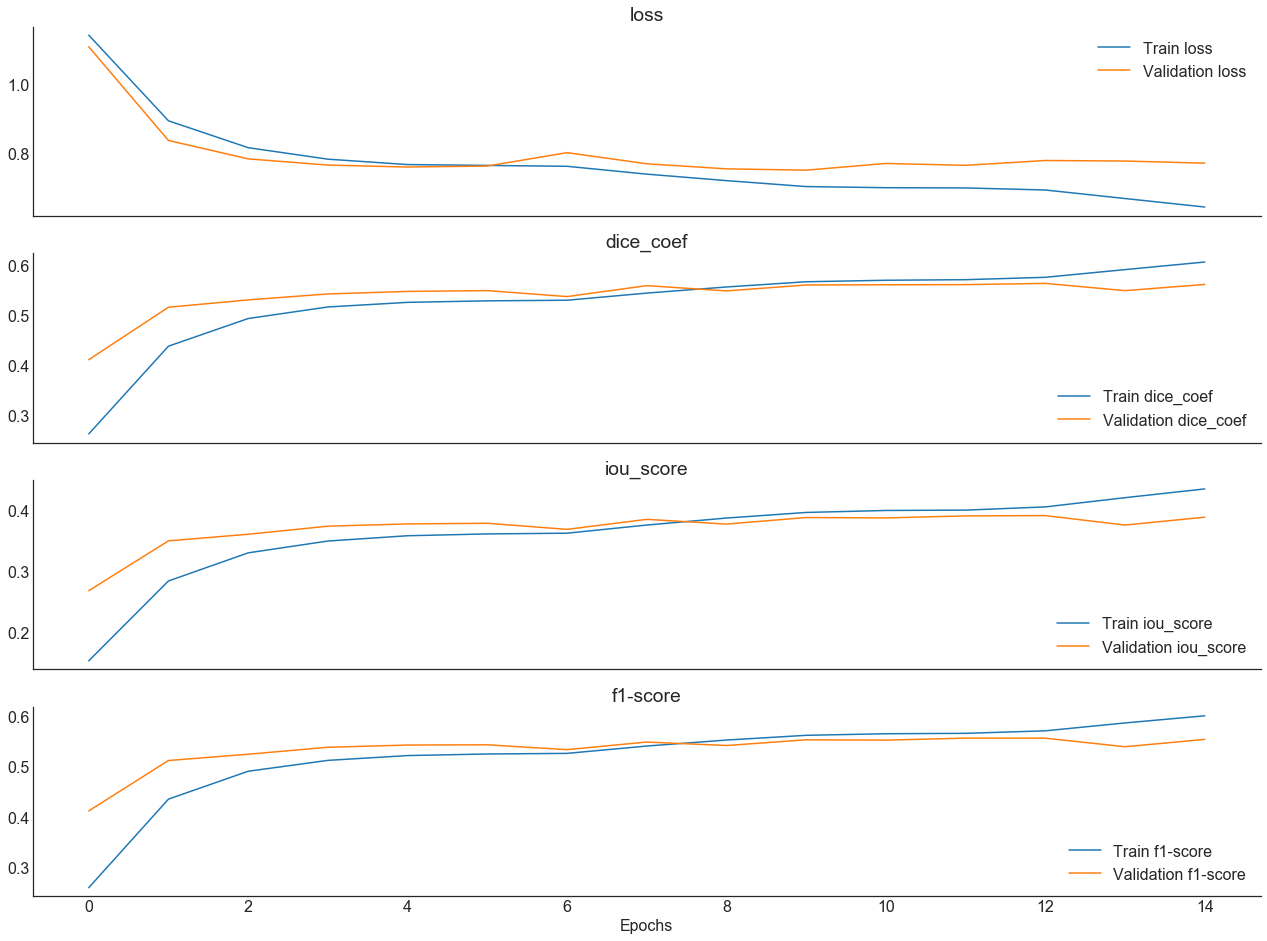

In [41]:
plot_metrics(history1, metric_list=['loss', 'dice_coef', 'iou_score', 'f1-score'])

# Fold 2

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Epoch 1/15
 - 1710s - loss: 1.1307 - dice_coef: 0.2758 - iou_score: 0.1606 - f1-score: 0.2717 - val_loss: 1.0935 - val_dice_coef: 0.4129 - val_iou_score: 0.2634 - val_f1-score: 0.4041
 - lr: 0.00998 - momentum: 0.90 
Epoch 2/15
 - 1616s - loss: 0.8970 - dice_coef: 0.4320 - iou_score: 0.2803 - f1-score: 0.4305 - val_loss: 0.8378 - val_dice_coef: 0.5188 - val_iou_score: 0.3500 - val_f1-score: 0.5119
 - lr: 0.01799 - momentum: 0.90 
Epoch 3/15
 - 1627s - loss: 0.8180 - dice_coef: 0.4929 - iou_score: 0.3292 - f1-score: 0.4897 - val_loss: 0.8100 - val_dice_coef: 0.5188 - val_iou_score: 0.3502 - val_f1-score: 0.5129
 - lr: 0.01391 - momentum: 0.90 
Epoch 4/15
 - 1627s - loss: 0.7865 - dice_coef: 0.5144 - iou_score: 0.3475 - f1-score: 0.5104 - val_loss: 0.7634 - val_dice_coef: 0.5453 - val_iou_score: 0.3751 - val_f1-score: 0.5399
 - lr: 0.00591 - momentum: 0.90 
Epoch 5/15
 - 1621s - loss:

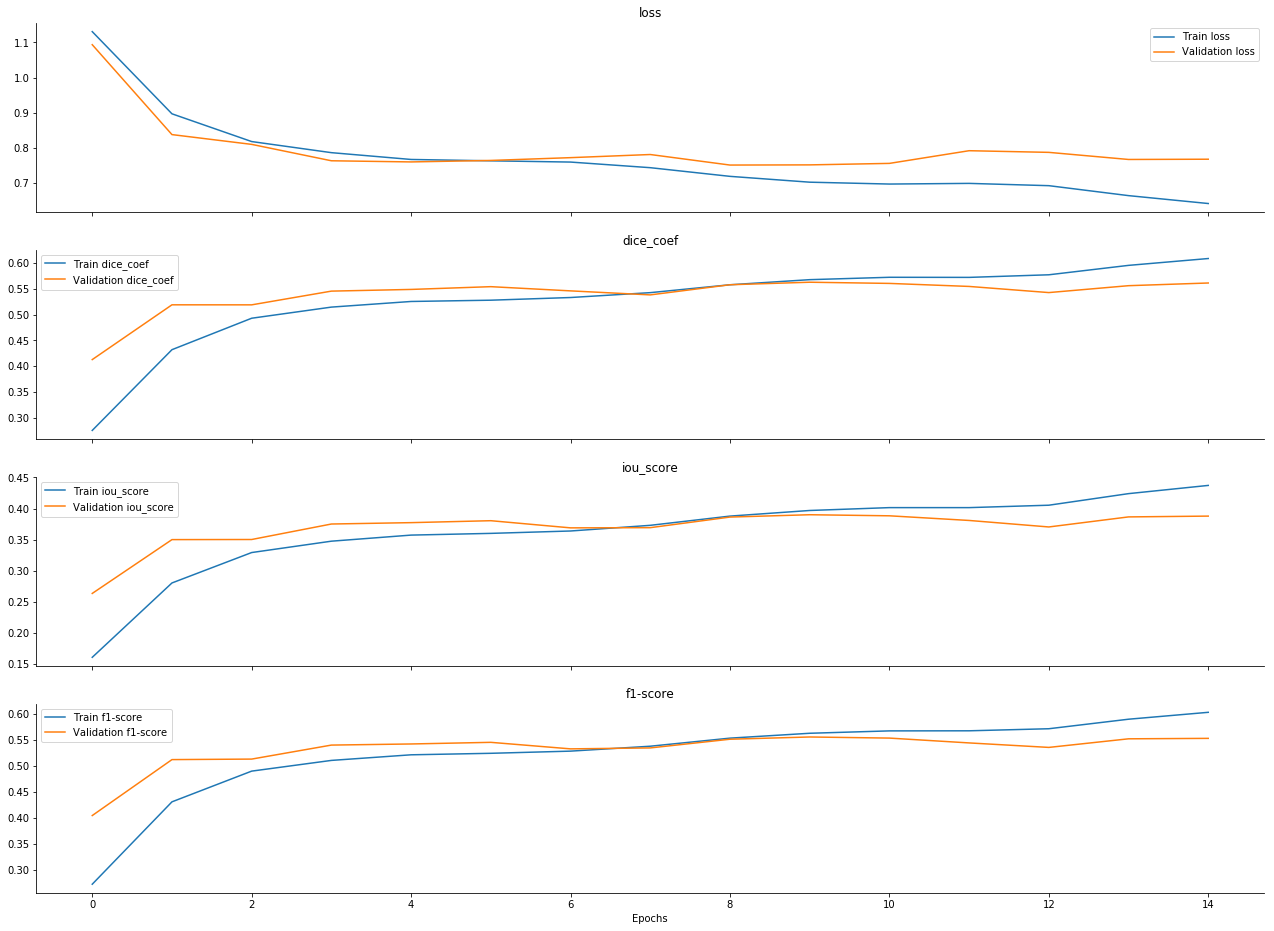

In [11]:
X_train = kfold_set[kfold_set['fold_1'] == 'train']
X_val = kfold_set[kfold_set['fold_1'] == 'validation']

model_s = sm.Unet(backbone_name=BACKBONE, 
                  encoder_weights='imagenet',
                  classes=N_CLASSES,
                  activation='sigmoid',
                  input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_1_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
oneCycleLR = OneCycleLR(max_lr=LEARNING_RATE, maximum_momentum=0.9, minimum_momentum=0.9)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, oneCycleLR]
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)

model = multi_gpu_model(model_s, gpus=N_GPUS)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)

history2 = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

plot_metrics(history2, metric_list=['loss', 'dice_coef', 'iou_score', 'f1-score'])

# Fold 3

In [11]:
X_train = kfold_set[kfold_set['fold_2'] == 'train']
X_val = kfold_set[kfold_set['fold_2'] == 'validation']

model_s = sm.Unet(backbone_name=BACKBONE, 
                  encoder_weights='imagenet',
                  classes=N_CLASSES,
                  activation='sigmoid',
                  input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_2_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
oneCycleLR = OneCycleLR(max_lr=LEARNING_RATE, maximum_momentum=0.9, minimum_momentum=0.9)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, oneCycleLR]
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)

model = multi_gpu_model(model_s, gpus=N_GPUS)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)

history3 = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

plot_metrics(history3, metric_list=['loss', 'dice_coef', 'iou_score', 'f1-score'])

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Epoch 1/15
 - 1694s - loss: 1.1307 - dice_coef: 0.2758 - iou_score: 0.1606 - f1-score: 0.2717 - val_loss: 1.0893 - val_dice_coef: 0.4128 - val_iou_score: 0.2634 - val_f1-score: 0.4041
 - lr: 0.00998 - momentum: 0.90 
Epoch 2/15
 - 1605s - loss: 0.8970 - dice_coef: 0.4320 - iou_score: 0.2802 - f1-score: 0.4305 - val_loss: 0.8387 - val_dice_coef: 0.5181 - val_iou_score: 0.3498 - val_f1-score: 0.5119
 - lr: 0.01799 - momentum: 0.90 
Epoch 3/15
 - 1606s - loss: 0.8180 - dice_coef: 0.4929 - iou_score: 0.3292 - f1-score: 0.4897 - val_loss: 0.8090 - val_dice_coef: 0.5192 - val_iou_score: 0.3503 - val_f1-score: 0.5130
 - lr: 0.01391 - momentum: 0.90 
Epoch 4/15
 - 1601s - loss: 0.7864 - dice_coef: 0.5144 - iou_score: 0.3475 - f1-score: 0.5104 - val_loss: 0.7642 - val_dice_coef: 0.5450 - val_iou_score: 0.3748 - val_f1-score: 0.5397
 - lr: 0.00591 - momentum: 0.90 
Epoch 5/15
 - 1605s - loss:

KeyboardInterrupt: 